## Background

A canonical inverse problem is to infer the spatially varying parameter field $K(x)$ in the following elliptic PDE
$$
-\nabla\cdot\left[ K \nabla h\right] = f,
$$
where $h(x)$ is the solution of the PDE and $f(x)$ is a source term.   We consider this PDE in a one dimensional (i.e., $x\in\mathbb{R}$) setting with boundary conditions given by
$$
\begin{aligned}
h(0) &= 0\\
\left. \frac{\partial h}{\partial x}\right|_{x=1} &= 0.
\end{aligned}
$$

This equation can be used to describe many different diffusive processes, such as heat conduction, groundwater flow, and contaminant diffusion.    This example interprets the PDE in the context of groundwater flow, meaning that $h(x)$ represents the hydraulic head in a confined aquifer, $f(x)$ represents recharge of water entering the aquifer, and $K(x)$ is the hydraulic conductivity, which describes how difficult it is for water to pass through the aquifer.

The hydraulic head $h(x)$ can be measured at individual points $x_1,x_2,\ldots,x_M$ by drilling boreholes into an aquifer and measuring the pressure in the borehole.  The conductivity $K(x)$ however, cannot be observed directly.   We will therefore consider estimating the hydraulic conductivity $K(x)$ from noisy measurements of $h(x_1), h(x_2),\ldots, h(x_M)$.



**The goal of this example is to demonstrate the use of MUQ for solving Bayesian inverse with PDE models.**   The implementation of the model itself will not be discussed in detail.   The implementation of the PDE solver, adjoint gradients, and Hessian information is described in detail in the [FlowEquation](../../../../Modeling/FlowEquation/python/DarcyFlow.ipynb) modeling example.

### Imports
This example will use many different MUQ modules as well as the `FlowEquation` class defined in [FlowEquation.py](FlowEquation.py).   Here we import everything we will need later on, including numpy and matplotlib.

In [1]:
import muq.Modeling as mm 
import muq.SamplingAlgorithms as ms 
import muq.Utilities as mu
import muq.Approximation as ma 
import muq.Optimization as mo

from FlowEquation import FlowEquation

import numpy as np
import matplotlib.pyplot as plt 

## Inverse Problem Formulation

For notational simplicity, let $\theta = \log K$.   In this example, we will define and subsequently sample a posterior density
$$
\pi(\theta | y=y_{obs}) \propto \pi(y=y_{obs} | \theta) \pi(\theta),
$$
where $y_{obs}$ is a vector of observed hydraulic heads at the points $x_1,\ldots, x_M$.   The observable variable $y$ is defined in terms of the PDE solution $h(x)$ evaluated at the observation locations:
$$
y = \left[ \begin{array}{c} h(x_1) + \epsilon_1\\ h(x_2)+ \epsilon_2\\ \vdots\\ h(x_M)+ \epsilon_M \end{array}\right],
$$
where each $\epsilon_i\sim N(0,\sigma_\epsilon^2)$ is an independent Gaussian random variable with variance $\sigma_\epsilon^2$.   This Gaussian assumption is common in practice, but may not be applicable in real-world situations where more complicated modeling errors and observation noise are present.   We will ignore these issues in this example.

For the prior, we will assume that $K(x)$ is a lognormal process and use MUQ's Gaussian process utilities to define $\pi(\theta)$.  

#### Discretization
We assume that $x\in\Omega=[0,1]$ and consider a uniform division of the domain $\Omega$ into $N$ sized cells.  There are $N+1$ nodes in the discretization.   To solve the PDE, we will use a linear finite element discretization.  The hydraulic head $h(x)$ is therefore piecewise linear and defined in terms of $N+1$ coefficients.  The hydraulic conductivity $K(x)$ is piecewise constant and can be represented with $N$ degrees of freedom. 

The `Discretization` class defined below holds information about the spatial discretization.


In [2]:
class Discretization:
    
    def __init__(self,numCells):
        self.numCells = numCells
        self.numNodes = numCells+1

        self.nodeLocs = np.linspace(0,1,numCells+1)

        self.cellLocs = 0.5*(self.nodeLocs[:-1] + self.nodeLocs[1:]).reshape(1,-1)

In [3]:
# Define the mesh
numCells = 50
mesh = Discretization(numCells)

#### Prior Distribution
By definition, the conductivity field $K(x)$ must be positive.   We will therefore define a prior distribution $\log K(x)$ to ensure that $K(x)>0$.   In particular, we will model the log conductivity field as a zero mean Gaussian process with covariance kernel $k(x,x^\prime)$:

$$
\log K(x) \sim GP(0,k(x,x^\prime))
$$

Here, we employ a Matern kernel with parameter $\nu=3/2$.  This kernel takes the form

$$
k(x,x^\prime) = \sigma^2 \left(1+\frac{\sqrt{3}\|x-x^\prime\|}{L}\right)\exp\left[-\frac{\sqrt{3}\|x-x^\prime\|}{L}\right],
$$

where $\sigma^2$ is the marginal variance of the prior distribution and $L$ is the correlation lengthscale of the kernel.  Note that this kernel results in random fields that have continuous first derivatives, but discontinuous second derivatives.   More generally, Matern kernels with $\nu=p+1/2$ result in fields with $p$ continuous derivatives.

The MUQ `GaussianProcess` class is constructed from a mean function and a covariance kernel.  The `GaussianProcess::Discretize` function can then to used to discretize the continuous Gaussian Process.  `Discretize` takes a vector of points and constructs a finite dimensional Gaussian distribution by evaluating the mean function at each point and the covariance kernel at each pair of points.  

Note that this is not always the best way to discretize a Gaussian Process.   For example, if the field $K(x)$ is represented with a finite number of basis functions $\phi_i(x)$, then it would be preferrable to project the Gaussian process onto the span of the basis functions.  This approach is skipped here for simplicity, but can be important, especially when $\phi_i(x)$ are high order or spectral basis functions.

<img src=Logk.svg width=600></img>

Our discretization of the PDE (see [DarcyFlow.ipynb](../../../../Modeling/FlowEquation/python/DarcyFlow.ipynb)) assumes that $K(x)$ is piecewise constant over grid cell (see Figure above).  Formally setting $\log K_i$ to the average of $\log K(x)$ over the cell $[x_i,x_{i+1})$ would result in a prior covariance matrix of the form

$$
\text{Cov}\left[\log K_i, \log K_j\right] = \frac{1}{(x_{i+1}-x_{i})(x_{j+1}-x_{j})}\int_{x_i}^{x_{i+1}} \int_{x_j}^{x_{j+1}} k(x_1,x_2) \,\,dx_2dx_1
$$

where $x_i$ is the location of the node on the left edge of cell $i$.  Here we approximate this covariance by simply evaluating the covariance kernel at the centroids of the cells: 

$$
\text{Cov}\left[\log K_i, \log K_j\right] \approx k\left(\frac{1}{2}(x_i + x_{i+1}),\,\, \frac{1}{2}(x_j + x_{j+1}) \right).
$$

Note that this is equivalent to approximating the integrals with a midpoint rule and a single interval.

**The vector $\log K = \left[\log K_1, \ldots, \log K_N\right]$ will be used to denote the collection of log conductivities on each cell.** 

In [4]:
def CreatePrior(mesh):
    
    # Define the prior distribution
    priorVar    = 1.0
    priorLength = 0.2
    priorNu     = 3.0/2.0
    
    xDim = 1     # Dimension of x
    fieldDim = 1 # Dimension of state variable in random field (i.e., dimension of K(x))
    
    covKernel = ma.MaternKernel(xDim, priorVar, priorLength, priorNu) # The first argument "1" specifies we are working in 1d
    
    meanFunc = ma.ZeroMean(xDim,fieldDim) # dimension of x, components in k(x) if it was vector-valued

    priorGP = ma.GaussianProcess(meanFunc,covKernel)

    return priorGP.Discretize(mesh.cellLocs)

In [5]:
priorDist = CreatePrior(mesh)
priorDens = priorDist.AsDensity() # <- Create a ModPiece that evaluates the log density of the Gaussian prior

#### True data
After discretizing the PDE, the hydraulic head $h(x)$ is represented as a piecewise linear function characterized by values at the $N+1$ nodes in the discretization.    We will assume that every $P=\lceil (N+1)/M\rceil$ of these nodes is observed, resuling in a total of $M$ hydraulic noisy head observations.  Let $y_{obs}$ denote these observations.  

For this example, we will synthetically generate data $y_{obs}$ using a "true" log conductivity field $\log K(x) = \cos(10x)$ and a mesh with $2N$ cells.  Noise with variance $\sigma^2$ is added to the model output to simulate $y_{obs}$.

In [2]:
def GetTrueLogConductivity(mesh):
    return np.cos(10.0*mesh.cellLocs)

The `SliceOperator` class in MUQ is used to downscale the model output.   Using numpy notation, the output of `SliceOperator` for an input vector $x$ is `x[startInd:endInd:skip]`.   The arguments to the `SliceOperator` constructor are `x.shape[0]`, `startInd`, `endInd`, and `skip`.

In [7]:
def GenerateData(mesh, obsThin, obsVar, numRefine=2):

    # Generate the data
    fineMesh = Discretization(numRefine*mesh.numCells)
    trueCond = np.exp( GetTrueLogConductivity(fineMesh) )

    # Create the model with twice the mesh resolution
    recharge = np.ones(fineMesh.numCells)
    mod = FlowEquation(recharge)

    # Solve the forward problem with the true conductivity
    trueSol = mod.Evaluate( trueCond )[0]

    # Take every N node as an "observation"
    slicer = mm.SliceOperator(fineMesh.numNodes, 0, fineMesh.numCells, numRefine*obsThin)
    
    yobs = slicer.Evaluate([trueSol])[0] + np.sqrt(obsVar)*np.random.randn(slicer.outputSizes[0])
    
    return yobs, trueSol, fineMesh 

In [8]:
# The value of thinning parameter "P"
obsThin = 4  

# \sigma_{\epsilon}^2
obsVar = 0.01*0.01 

# Controls the number of cells in the fine mesh used to generate data (numCells = numRefine*N)
numRefine = 2 

# Generate the data
data, trueHead, fineMesh = GenerateData(mesh, obsThin, obsVar,2)

We can now plot the noisy observational data and the true hydraulic head $h(x)$ that generated it.

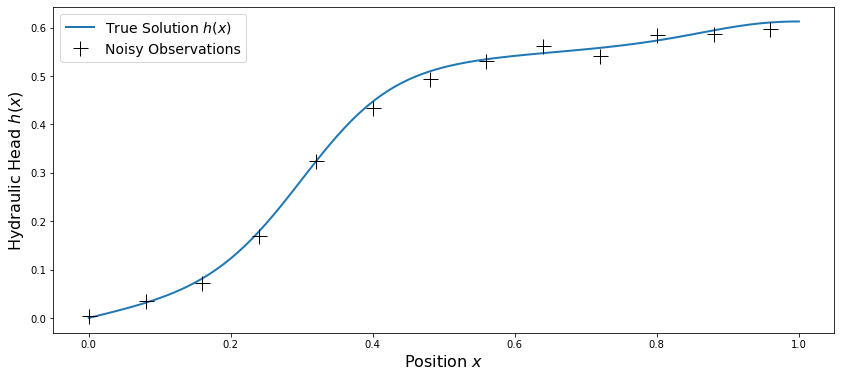

In [9]:
plt.figure(figsize=(14,6))
plt.plot(fineMesh.nodeLocs, trueHead, label='True Solution $h(x)$', linewidth=2)
plt.plot(fineMesh.nodeLocs[::obsThin*numRefine], data, '+k', label='Noisy Observations', markersize=15)

plt.legend(fontsize=14)
plt.xlabel('Position $x$',fontsize=16)
plt.ylabel('Hydraulic Head $h(x)$', fontsize=16)
plt.show()

#### Likelihood Function

To define a likelihood function $\pi(y|\theta)$, we need to construct a statistical model relating the PDE output $[h(x_0), h(x_P),\ldots, h(x_M)]$ to the observable quantity $y$.   Here, we assume that $y$ is  related to the hydraulic heads through an additive Gaussian error model

$$
y = \left[ \begin{array}{l} h(x_{0}; \theta)\\ h(x_{P}; \theta)\\ h(x_{2P}; \theta)\\ \vdots\\ h(x_M; \theta) \end{array} \right] + \epsilon,
$$

where $\epsilon\sim N(0,\sigma_{\epsilon}^2I)$ is an $M$-dimensional normal random variable with variance $\sigma_{\epsilon}^2$.   With this noise model, the distribution of the observable quantity $y$ given log conductivities $\theta$  is then just normal distribution centered at the model output

$$
\pi(y | \theta) = N\left([h(x_0), h(x_P),\ldots, h(x_M)], \,\, \sigma_{\epsilon}^2I\right)
$$

The `ConstructLikelihood` function uses a MUQ `WorkGraph` to compose modeling components that together, compute the likelihood function.    In particular, operations for $\theta\rightarrow K$, $K\rightarrow h$, $h\rightarrow [h(x_0),\ldots, h(x_M)]$, and finally $[h(x_0), \ldots, h(x_M)]\rightarrow \pi(y | \theta)$.

In [10]:
def ConstructLikelihood(mesh, data, obsThin, obsVar, forwardMod):
   
    graph = mm.WorkGraph()
    
    # Create a exponential operator for \theta -> K
    graph.AddNode(mm.ExpOperator(mesh.numCells), "Conductivity")
    
    # Add the forward model, which evaluates K->h
    graph.AddNode(forwardMod, "Forward Model")
    graph.AddEdge("Conductivity", 0, "Forward Model", 0)
    
    # Thin the model output to coincide with the observation locations 
    graph.AddNode(mm.SliceOperator(mesh.numNodes,0,mesh.numCells,obsThin), "Observables")
    graph.AddEdge("Forward Model", 0, "Observables", 0)
    
    # Create the Gaussian likelihood that evaluates [h(x_0),\ldots, h(x_M)]\rightarrow \pi(y | \theta) 
    likelihood = mm.Gaussian(data, obsVar*np.ones(data.shape[0]))
    graph.AddNode(likelihood.AsDensity(), "Likelihood")
    graph.AddEdge("Observables", 0, "Likelihood", 0)
    
    # Create a file LikelihoodGraph.png that visualizes the sequence of operations
    graph.Visualize("LikelihoodGraph.png")
    
    return graph.CreateModPiece("Likelihood"), graph.CreateModPiece("Forward Model")

In [11]:
# Define the forward model
recharge = np.ones(mesh.numCells)
forwardMod = FlowEquation(recharge)

# Build the likelihood function and the mapping from logK->h
likelihood, model = ConstructLikelihood(mesh, data, obsThin, obsVar, forwardMod)

If [graphviz](https://graphviz.org/) is installed on your computer, the `graph.Visualize()` function will produce a file called "LikelihoodGraph.png" with a visualization of the components making up the likelihood function.   The following markdown cell displays the image that is produced.

<img src="./LikelihoodGraph.png" alt="Likelihood Graph" width="300"/>

#### Create Posterior
Using the likelihood function and prior density defined above, it is now possible to combine them to define the posterior density.   The `DensityProduct` ModPiece is used for this.  It takes 2 or more inputs representing log densities and returns the log of the density product (i.e., the sum of the log densities).

In [12]:
def ConstructPosterior(prior, likelihood):
   
    ##### Likelihood Function
    graph = mm.WorkGraph()
    graph.AddNode(mm.IdentityOperator(mesh.numCells), "Log Conductivity")
    
    graph.AddNode(mm.ExpOperator(mesh.numCells), "Conductivity")
    graph.AddEdge("Log Conductivity", 0, "Conductivity", 0)
    
    graph.AddNode(forwardMod, "Forward Model")
    graph.AddEdge("Conductivity", 0, "Forward Model", 0)
    
    graph.AddNode(mm.SliceOperator(mesh.numNodes,0,mesh.numCells,obsThin), "Observables")
    graph.AddEdge("Forward Model", 0, "Observables", 0)
    
    likelihood = mm.Gaussian(data, obsVar*np.ones(data.shape[0]))
    
    graph.AddNode(likelihood.AsDensity(), "Likelihood")
    graph.AddEdge("Observables", 0, "Likelihood", 0)
    
    #### Prior Density
    graph.AddNode(prior, "Prior")
    graph.AddEdge("Log Conductivity", 0, "Prior", 0)
    
    #### Posterior Density
    graph.AddNode(mm.DensityProduct(2), "Posterior")
    graph.AddEdge("Prior",0,"Posterior",0)
    graph.AddEdge("Likelihood",0,"Posterior",1)

    graph.Visualize("PosteriorGraph.png")
    
    return graph.CreateModPiece("Posterior")

In [13]:
posterior = ConstructPosterior(priorDens, likelihood)

Like we did for the likelihood function above, it is possible to visualize the direct graph used to define the posterior density using the `Visualize` function of the `WorkGraph` class.

<img src="./PosteriorGraph.png" alt="Likelihood Graph" width="400"/>

## Compute MAP Point
Now that we've define the posterior, we can start trying to estimate the parameters $\theta = \log K$ in the model.  The following cell computes the maximum aposterior (MAP) point using MUQ's Newton-Steihaug trust region optimizer.   The optimizer assumes it is given a minimization problem, while we want to maximize the log posterior density.  The `ModPieceCostFunction` class allows us to specify a negative scaling of the log posterior to flip the maximization problem into a minimization problem that the optimizer can handle.    

In addition to the trust region solver used here, MUQ also can also leverage any method implemented in [NLOPT](https://nlopt.readthedocs.io/en/latest/).  Try changing the `'NewtonTrust'` string to `'LBFGS'` to use the NLOPT limited memory BFGS implementation.

In [14]:
def ComputeMAP(logPost, startPt):
    
    options = {
        'Algorithm' : 'NewtonTrust', # Newton-Steihaug trust region method.  Options also include NLOPT optimizers like LBFGS
        'PrintLevel' : 1,
        'Ftol.AbsoluteTolerance' : 1e-4
    }
    
    # Define the objective function as the negative log posterior 
    objective = mo.ModPieceCostFunction(logPost, -1.0)
    
    # Construct the optimizer and minimize the objective
    solver = mo.Optimizer.Construct(objective, options)
    xopt, fopt = solver.Solve([ startPt ])
    
    return xopt

In [15]:
# Use the prior mean as a starting point
startPt = priorDist.GetMean()

mapPt = ComputeMAP(posterior, startPt)

Using NewtonTrust optimizer...
  Iteration, TrustRadius,       fval,      ||g||
          0,       1.000,  4.303e+02,  6.502e+02
          1,       1.000,  4.737e+01,  1.126e+02
          2,       1.000,  1.519e+00,  2.705e+02
          3,       1.000,  -7.360e+01,  8.839e+01
          4,       1.000,  -9.952e+01,  7.717e+01
          5,       1.000,  -1.089e+02,  1.389e+01
          6,       1.000,  -1.102e+02,  8.724e+00
          7,       1.000,  -1.103e+02,  3.876e-01
          8,       1.000,  -1.103e+02,  2.429e-01
          9,       1.000,  -1.103e+02,  5.460e-02
         10,       1.000,  -1.103e+02,  6.643e-02


#### Plot the MAP Point

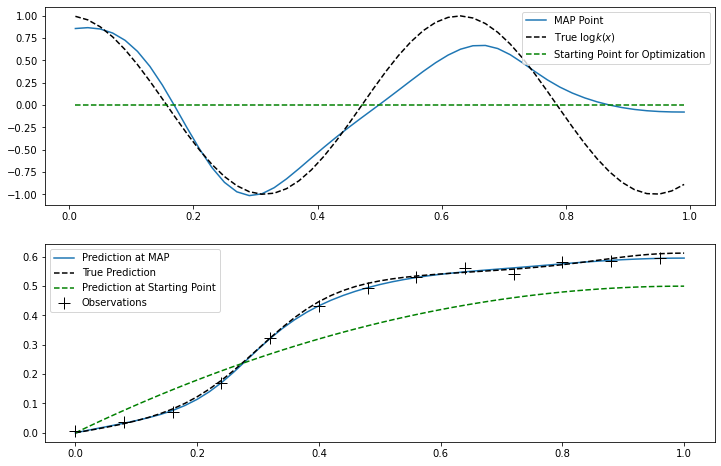

In [16]:
trueLogK = GetTrueLogConductivity(mesh).ravel()

fig, axs = plt.subplots(nrows=2,figsize=(12,8))
axs[0].plot(mesh.cellLocs.ravel(), mapPt,label='MAP Point')
axs[0].plot(mesh.cellLocs.ravel(), trueLogK, '--k', label='True $\log k(x)$')
axs[0].plot(mesh.cellLocs.ravel(), startPt, '--g', label='Starting Point for Optimization')
axs[0].legend()

truePred = model.Evaluate([trueLogK])[0]
mapPred = model.Evaluate([mapPt])[0]
startPred = model.Evaluate([startPt])[0]

axs[1].plot(mesh.nodeLocs, mapPred, label='Prediction at MAP')
axs[1].plot(mesh.nodeLocs, truePred,'--k',label='True Prediction')
axs[1].plot(mesh.nodeLocs, startPred, '--g', label='Prediction at Starting Point')
axs[1].plot(mesh.nodeLocs[0:-1:obsThin],data,'+k',markersize=12,label='Observations')
axs[1].legend()

plt.show()

## Sample Posterior with DILI

To sample the posterior distribution, we will employ MUQ's implementation of the dimension independent likelihood informed (DILI) method introduced in [Cui et al. 2015](https://arxiv.org/abs/1411.3688).   The idea is to decompose the parameter space into two subspaces: one "likelihood informed" subspace where the posterior distribution is significantly different than the prior, and a complementary subspace where the posterior distribution is approximately the same as the prior distribution.   Different MCMC kernels can be then be applied to each subspace.  If the MCMC sampler used in the complementary space is discretization invariant (e.g., the precondition Crank-Nicolson method), then the entire DILI sampling scheme is discretization invariant.

The subspaces are constructed by comparing the relative "strengths" of the likelihood and prior through the generalized eigenvalue problem 

$$
Hv = \lambda \Gamma^{-1}v,
$$

where $\Gamma^{-1}$ is the prior precision matrix, and $H$ is the Hessian of the negative log likelihood.  In this example, we will use the exact Hessian at the MAP point.  The `HessianType` option is therefore set to `Exact` in the `opt` dictionary below.   Gauss Newton approximations of the Hessian are also commonly employed in practice (see Eq. (19) of [Cui et al. 2015](https://arxiv.org/pdf/1411.3688.pdf)).  This can be accomplished in MUQ by changing the `HessianType` option to `GaussNewton`.    Note that the `Exact` Hessian is not always positive definite across the entire parameter space.   In this example, we are only using the Hessian at the MAP point, so this will not be an issue.  When the `Adapt Interval` option is nonzero however, the likelihood informed subspace will be formed from an average Hessian and, in that case, it is generally advisable to use the `GaussNewton` Hessian.


#### Choosing Starting Points
Metrics from MUQ's `MCMC::Diagnostics` class, like the multivariate potential scale reduction factor (MPSRF), can be used to evaluate whether our DILI sampler has converged.  To compute these metrics however, we need to run multiple chains from a diffuse set of initial points.  Generating these points in high dimensions can be challenging.   In this example, we use a Gaussian approximation of the posterior (i.e., the Laplace Approximation) constructed using the Hessian of the log-posterior at the MAP point.   Let $\theta^\ast$ denote the MAP point and $H$ the Hessian of the $2\pi(\theta | y=y_{obs})$.  The posterior can then be approximated as

$$
\pi(\theta | y=y_{obs}) \approx \tilde{\pi}(\theta|y=y_{obs}) = N(\theta^\ast, H^{-1})
$$

The DILI implementation in MUQ uses a low rank approximation of $H^{-1}$ to define the likelihood-informed and complementary subspaces.   We can use the same low rank structure to generate samples of the approximate posterior.  Let $\theta_{pr}\sim \pi(\theta)$ be a prior random variable and let $z_{lis}$ be a standard normal random variable in $\mathbb{R}^N_{LIS}$.  From these random variables we can construct a random variable $\theta_{app}\sim \tilde{\pi}(\theta|y=y_{obs})$ through

$$
\theta_{app} = \theta^\ast + Vz_{lis} + P(\theta_{pr}-\mu_{pr}),
$$

where the columns of $V$ span the likelihood-informed subspace while also accounting for posterior correlations and the matrix $P$ is an oblique projector onto the complementary space.   Internally, MUQ constructs the matrix $V$ by projecting $H^{-1}$ onto the likelihood-informed subspace and then using a matrix square root to decorrelate the projected random variable.

Fortunately, in this example we do not need consider the details of constructing $V$ and $P$.  Both of these are constructed in MUQ's `DILIKernel` class and can be applied using the `ToCS`, `ToLIS`, and `FromLIS` functions.  The `ToCS` function takes a vector in the full $N$ dimensional parameter space and projects it onto the prior-dominated complimentary space; it computes $P\theta_{pr}$  It returns another $N$ diemnsional vector.    The `ToLIS` function has a similar purpose: it takes and $N$ dimensional vector and projects it onto the likelihood-informed subspace.  However, `ToLIS` returns a vector with $N_{LIS}<N$ components.   The `FromLIS` function can then be used to map a point on the $N_{LIS}$-dimensional likelihood-informed subspace to the full $N$-dimensional space.

To generate diffuse initial starting points for the chains, we can "inflate" the variance of $z_{lis}$ and $\theta_{pr}$.   Below, the `SampleInflatedLaplace` function accomlishes this by multiplying $z_{lis}$ and $\theta_{pr}-\mu_{pr}$ by an inflation factor of $1.2$.

In [17]:
def SampleInflatedLaplace(diliKernel, priorDist, mapPt):
    
    inflation = 1.2
    
    diliKernel.CreateLIS([mapPt])
    print("LIS Dimension: ", diliKernel.LISDim())
    
    csSamp = diliKernel.ToCS( mapPt + inflation*(priorDist.Sample() - priorDist.GetMean()) )
    lisSamp = diliKernel.FromLIS( diliKernel.ToLIS(mapPt) + inflation*np.random.randn(diliKernel.LISDim()) )
    
    return csSamp + lisSamp

#### Running the Sampler
We are now ready to define and run the DILI sampler.   The `SampleDili` function defines options for the MCMC samplers in both the likelihood-informed subspace and complementary space.  It then constructs the DILI sampler, samples the inflated Gaussian posterior approxiamtion to obtain an initial point, and runs the chain.   

Note that the pCN (`CrankNicolsonProposal`) used in the complementary space has a stepsize parameter of $\beta=1$.   This causes the pCN algorithm to use independent draws of the prior distribution as MCMC proposals.  Because the complementary space is approximately the same as prior distribution, this still results in large acceptance rates.

In [18]:
def SampleDILI(posterior, mapPt, priorDist, numSamps):
    
    lisOpts = {
        'Method' : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "MALAProposal",
        "Prop.StepSize" : 0.4
    }
    
    csOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 1.0,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps,
        "BurnIn" : 0,
        "PrintLevel" : 3,
        "HessianType" : "Exact",
        "Adapt Interval" : 0, # Do not adapt
        "Initial Weight" : 100,
        "Prior Node" : "Prior",
        "Likelihood Node" : "Likelihood",
        "LIS Block": "LIS",
        "LIS" : lisOpts,
        "CS Block": "CS",
        "CS" : csOpts
    }
    
    # create a sampling problem
    problem = ms.SamplingProblem(posterior)
    
    # Construct the DILI kernel and MCMC sampler
    kernel = ms.DILIKernel(opts, problem)
    
    sampler = ms.SingleChainMCMC(opts, [kernel])
    
    startPt = SampleInflatedLaplace(kernel, priorDist, mapPt)
    return sampler.Run([startPt]) 

In [19]:
numSamps = 30000
numChains = 4
chains = [None]*numChains

for i in range(numChains):
    print('\n===============================')
    print('Running DILI Chain ', i+1, ' / ', numChains)
    print('-------------------------------')
    
    chains[i] = SampleDILI(posterior, mapPt, priorDist, numSamps)
    


Running DILI Chain  1  /  4
-------------------------------
LIS Dimension:  9
Starting single chain MCMC sampler...
  10% Complete
    Block 0:
       LIS (dim=9): MHKernel acceptance Rate = 56%
       CS: MHKernel acceptance Rate = 76%
  20% Complete
    Block 0:
       LIS (dim=9): MHKernel acceptance Rate = 57%
       CS: MHKernel acceptance Rate = 75%
  30% Complete
    Block 0:
       LIS (dim=9): MHKernel acceptance Rate = 57%
       CS: MHKernel acceptance Rate = 75%
  40% Complete
    Block 0:
       LIS (dim=9): MHKernel acceptance Rate = 57%
       CS: MHKernel acceptance Rate = 75%
  50% Complete
    Block 0:
       LIS (dim=9): MHKernel acceptance Rate = 57%
       CS: MHKernel acceptance Rate = 75%
  60% Complete
    Block 0:
       LIS (dim=9): MHKernel acceptance Rate = 57%
       CS: MHKernel acceptance Rate = 74%
  70% Complete
    Block 0:
       LIS (dim=9): MHKernel acceptance Rate = 58%
       CS: MHKernel acceptance Rate = 74%
  80% Complete
    Block 0:
       L

#### Assess Convergence
We now use the multiple DILI chains to assess convergence with the MPSRF diagnostic described in [[Brooks and Gelman, 1998](https://www.tandfonline.com/doi/abs/10.1080/10618600.1998.10474787)] and the Multivariate effective sample size of [[Vats et al., 2019](https://doi.org/10.1093/biomet/asz002)].   Note that when computing the MPSRF, we are also passing the `'Split':True` option, which follows the suggestions of [[Vehtari et al., 2021](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1214%2F20-BA1221&v=8607c76e)] and splits each chain in half.

In [3]:
diliESS = np.sum( [chain.ESS(method='MultiBatch')[0] for chain in chains])

diliMPSRF = ms.Diagnostics.Rhat(chains, {'Split':True, 'Normalize':False, 'Multivariate':True})

print('DILI Diagnostics:\n  Multivariate ESS: {:5d}\n  MPSRF: {:5f}'.format(int(diliESS),diliMPSRF[0]))

if(diliMPSRF[0]>1.01):
    print('\nHAS NOT CONVERGED!')
else:
    print('\nCONVERGED!')

NameError: name 'chains' is not defined

#### Plot DILI Results

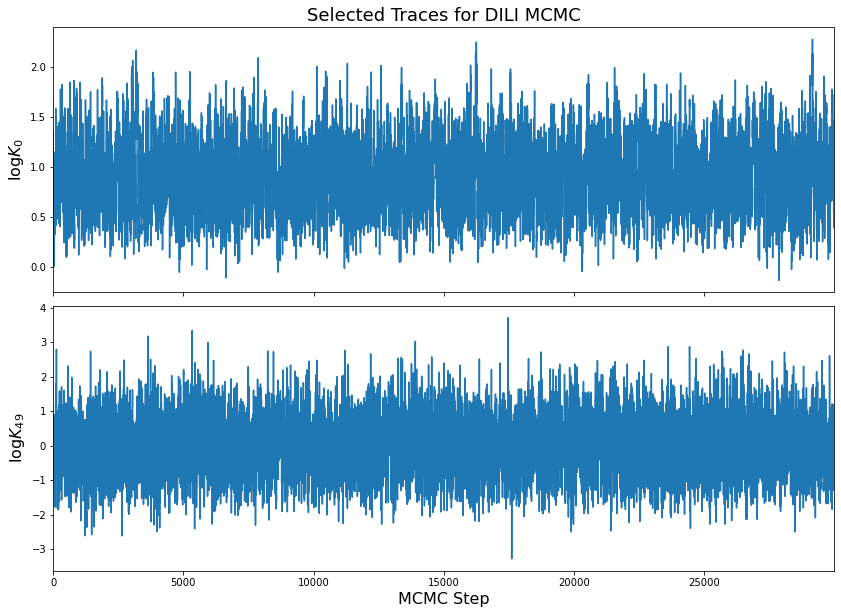

In [21]:
samps = chains[2].AsMatrix()

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(14,10))
axs[0].plot(samps[0,:])
axs[0].set_ylabel('$\log K_0\f$',fontsize=16)
axs[0].set_title('Selected Traces for DILI MCMC',fontsize=18)

axs[1].plot(samps[-1,:])
axs[1].set_ylabel('$\log K_{{ {} }}$'.format(samps.shape[0]-1),fontsize=16)
axs[1].set_xlabel('MCMC Step', fontsize=16)
axs[1].set_xlim([0,samps.shape[1]-1])

plt.subplots_adjust(hspace=0.05)

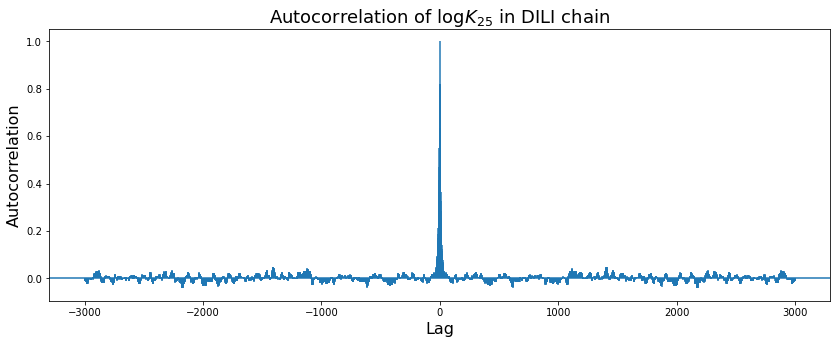

In [22]:
plt.figure(figsize=(14,5))

plotInd = int(0.5*samps.shape[0])
plt.acorr(samps[plotInd,:]-np.mean(samps[plotInd,:]),maxlags=3000)
plt.xlabel('Lag', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.title('Autocorrelation of $\log K_{{ {} }}$ in DILI chain'.format(plotInd),fontsize=18)
plt.show()

## Sample Posterior with pCN
For comparison with the DILI results, we will use a standard preconditioned Crank-Nicolson proposal.   This method is discretization invariant, but does not leverage the same structure as DILI and has much poorer performance.   Other geometry-aware enhancements of the pCN proposal are also available in MUQ (e.g., [$\infty$-MALA](https://mituq.bitbucket.io/source/_site/latest/classmuq_1_1SamplingAlgorithms_1_1InfMALAProposal.html)), but are not shown in this example.

In [28]:
def SamplePCN(posterior, startPt, numSamps):
    
    kernOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 0.05,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps, # number of Monte Carlo samples,
        "BurnIn" : 0,
        "PrintLevel" : 3,
        "KernelList" : "Kernel1",
        "Kernel1" : kernOpts
    }
    
    
    #create a sampling problem
    problem = ms.SamplingProblem(posterior)

    sampler = ms.SingleChainMCMC(opts,problem)

    return sampler.Run([startPt]) # Use a true posterior sample to avoid burnin

In [29]:
pcnChains = [None]*numChains

for i in range(numChains):
    print('\n===============================')
    print('Running pCN Chain ', i+1, ' / ', numChains)
    print('-------------------------------')
    
    pcnChains[i] = SamplePCN(posterior, chains[i][0].ToVector(), numSamps)


Running pCN Chain  1  /  4
-------------------------------
Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  20% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  30% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  40% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  50% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  60% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  70% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  80% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  90% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
  100% Complete
    Block 0:
      MHKernel acceptance Rate = 16%
Completed in 11.0137 seconds.

Running pCN Chain  2  /  4
-------------------------------
Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate = 18%
  20% Complete
    Block 0:
      MHKernel acceptance Rate

In [30]:
pcnESS = np.sum( [chain.ESS(method='MultiBatch')[0] for chain in pcnChains])

pcnMPSRF = ms.Diagnostics.Rhat(pcnChains, {'Split':True, 'Normalize':False, 'Multivariate':True})

print('pCN Diagnostics:\n  Multivariate ESS: {:5d}\n  MPSRF: {:5f}'.format(int(pcnESS),pcnMPSRF[0]))

if(pcnMPSRF[0]>1.01):
    print('\nHAS NOT CONVERGED!')
else:
    print('\nCONVERGED!')

pCN Diagnostics:
  Multivariate ESS:   904
  MPSRF: 5.832167

HAS NOT CONVERGED!


### Plot pCN Results

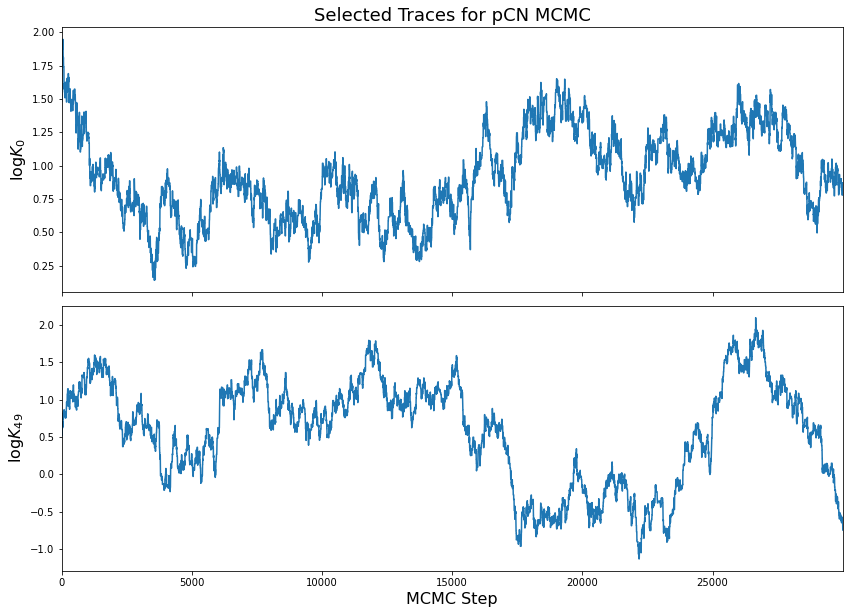

In [31]:
pcnSamps = pcnChains[0].AsMatrix()

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(14,10))
axs[0].plot(pcnSamps[0,:])
axs[0].set_ylabel('$\log K_0\f$',fontsize=16)
axs[0].set_title('Selected Traces for pCN MCMC',fontsize=18)

axs[1].plot(pcnSamps[-1,:])
axs[1].set_ylabel('$\log K_{{ {} }}$'.format(pcnSamps.shape[0]-1),fontsize=16)
axs[1].set_xlabel('MCMC Step', fontsize=16)
axs[1].set_xlim([0,pcnSamps.shape[1]-1])

plt.subplots_adjust(hspace=0.05)


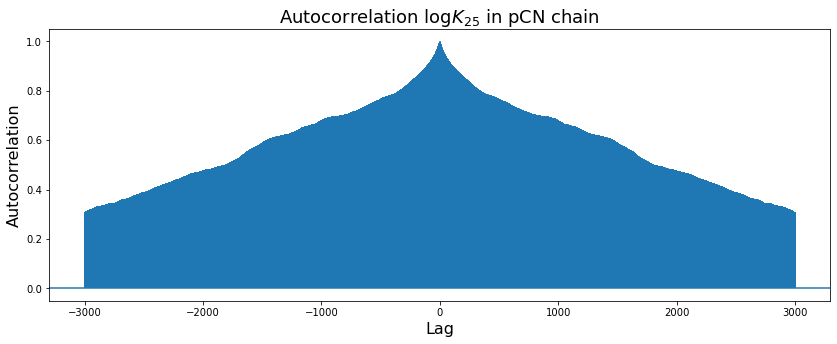

In [32]:
plt.figure(figsize=(14,5))

plt.acorr(pcnSamps[plotInd,:]-np.mean(pcnSamps[plotInd,:]),maxlags=3000)
plt.xlabel('Lag', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.title('Autocorrelation $\log K_{{ {} }}$ in pCN chain'.format(plotInd),fontsize=18)
plt.show()